In [1]:
#setup
data_dir='../Data/Weather'
#!ls $data_dir
state='NY'
m='PRCP_s20'

## Spectral Analysis of smoothed PRCP

## Loading libdaries and data
### Load the required libraries

In [2]:
# Enable automiatic reload of libraries
%load_ext autoreload
%autoreload 2 # means that all modules are reloaded before every command

%pylab inline
#%pylab inline
import numpy as np

import findspark
findspark.init()

#import sys
#sys.path.append('./lib')

from lib.numpy_pack import packArray,unpackArray

#from lib.Eigen_decomp import Eigen_decomp
from lib.YearPlotter import YearPlotter
from lib.decomposer import *
from lib.Reconstruction_plots import *


from lib.import_modules import import_modules,modules
import_modules(modules)

from lib.getFiles import *

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
import ipywidgets as widgets

print('version of ipwidgets=',widgets.__version__)

import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.22.0 	required version>=0.19.2

     numpy as    np 	version=1.14.2 	required version>=1.12.0

   sklearn as    sk 	version=0.19.1 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=2.3.0 	required version>=2.1.0

ipywidgets as ipywidgets 	version=7.1.2 	required version>=6.0.0

version of ipwidgets= 7.1.2


In [3]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py','lib/Reconstruction_plots.py','lib/decomposer.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)


### Read Statistics File

In [4]:
get_weather_files(state,data_dir)
!du -h $data_dir

1.9M	../Data/Weather/decon_NY_SNWD.parquet
76M	../Data/Weather/NY.parquet
1.9M	../Data/Weather/recon_NY_SNWD.parquet
420K	../Data/Weather/stations.parquet
1.6M	../Data/Weather/Weather_Stations.parquet
195M	../Data/Weather


In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print('keys from STAT=',measurements)

keys from STAT= dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


In [7]:
EigVec=STAT[m]['eigvec']
Mean=STAT[m]['Mean']

### Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [8]:
#read data
filename=data_dir+'/%s.parquet'%state
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.Measurement==m)
df=df.drop('State')
df.show(5)

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1948|[72 48 7A 48 85 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|DANSVILLE MUNI AP|
|USW00094704|   PRCP

## Computing decomposition for each row, and add columns for coefficients and residuals

Residuals are the remainder left after successive approximations:  
1) Original vector = $\vec{v}$

2) $\vec{r}_0=\vec{v}-\vec{\mu}$

3) $\vec{r}_1=\vec{r}_0-(\vec{v}\cdot \vec{u}_1) \vec{u}_1$

4) $\vec{r}_2=\vec{r}_1-(\vec{v}\cdot \vec{u}_2) \vec{u}_2$

5) $\vec{r}_3=\vec{r}_0-(\vec{v}\cdot \vec{u}_3) \vec{u}_3$  
6) ......

For each reidual $\vec{r}_i$ we compute it's square norm, which we will refer to as **residual norm** :
$$\|\vec{r}_i\|_2^2 = \sum_{j=1}^n (r_{i,j})^2$$  
The smaller tha norm, the better the approximation.

#### A few things we know from linear algebra:

1) The zero'th residual norm is the square distance of $\vec{v}$ from the mean $\vec{\mu}$

2) The $k$'th residual norm is the minimal square between $\vec{v}$ and a point that can be exspressed as
$$ \vec{w}_k = \vec{\mu} + \sum_{i=1}^k c_i \vec{u}_i$$
Where $c_1,\ldots,c_k$ are arbitrary real numbers. We call $\vec{w}_k$ the $k$'th approximation or reconstruction of $\vec{v}$.

3) The residual norms are non-increasing.  
4) The residual vector $\vec{r}_n$ is the zero vector. In other words, $\vec{w}_n = \vec{v}$.

`decompose_dataframe` axtracts the series from the row, computes the `k` to decomposition coefficients and 
the square norm of the residuals and constructs a new row that is reassembled into a new dataframe.  

For more details, use `%load lib/decomposer.py`

In [9]:
%%time
k=5
df2=decompose_dataframe(sqlContext,df,EigVec[:,:k],Mean).cache() # Make it possible to generate only first k coefficients.

CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 892 ms


In [10]:
%%time
print(df2.count())

16118
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.37 s


In [11]:
df2.show(1)

+-----------+-----------+--------------------+----+-----------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+--------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------------+
|Measurement|    Station|              Values|Year|          coeff_1|           coeff_2|            coeff_3|           coeff_4|           coeff_5|       dist_coast|        elevation|      latitude|         longitude|             name|             res_1|             res_2|             res_3|             res_4|              res_5|          res_mean|        total_var|
+-----------+-----------+--------------------+----+-----------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+--------------+------------------+-----------------+------------------+-----------

In [12]:

df2.show(1)

+-----------+-----------+--------------------+----+-----------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+--------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-----------------+
|Measurement|    Station|              Values|Year|          coeff_1|           coeff_2|            coeff_3|           coeff_4|           coeff_5|       dist_coast|        elevation|      latitude|         longitude|             name|             res_1|             res_2|             res_3|             res_4|              res_5|          res_mean|        total_var|
+-----------+-----------+--------------------+----+-----------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+--------------+------------------+-----------------+------------------+-----------

### Saving the decomposition in a Parquet file

In [13]:
df2.count()

16118

In [14]:
filename=data_dir+'/decon_'+state+'_'+m+'.parquet'
!rm -rf $filename
filename

'../Data/Weather/decon_NY_PRCP_s20.parquet'

In [15]:
df2.write.parquet(filename)

In [16]:
!du -sh $data_dir/*.parquet

76M	../Data/Weather/NY.parquet
1.6M	../Data/Weather/Weather_Stations.parquet
13M	../Data/Weather/decon_NY_PRCP_s20.parquet
1.9M	../Data/Weather/decon_NY_SNWD.parquet
1.9M	../Data/Weather/recon_NY_SNWD.parquet
420K	../Data/Weather/stations.parquet


## Plot mean and top eigenvectors

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

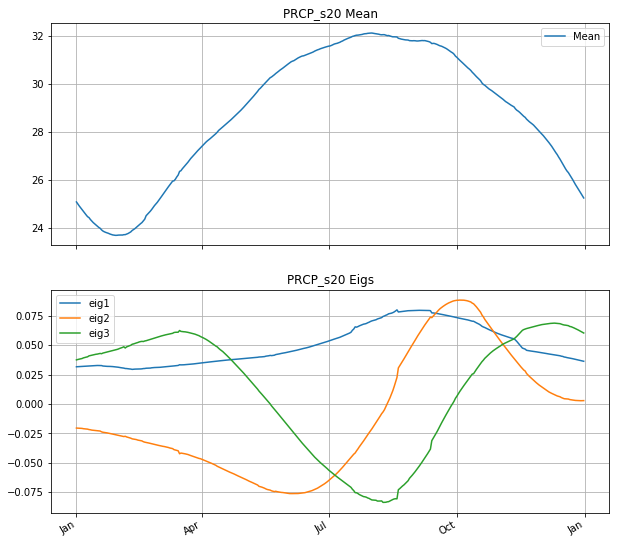

In [17]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,10));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

## plot Percentage of variance explained

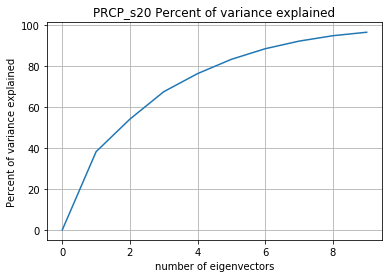

In [18]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title(m+' Percent of variance explained');

## Exploring the decomposition


### Intuitive analysis

In [19]:
#combine mean with Eigvecs and scale to similar range.
print(EigVec.shape)
_norm_Mean=Mean/max(Mean)*0.2
A=[_norm_Mean]+[EigVec[:,i] for i in range(EigVec.shape[1])]
Combined=np.stack(A).transpose()
Combined.shape

(365, 3)


(365, 4)

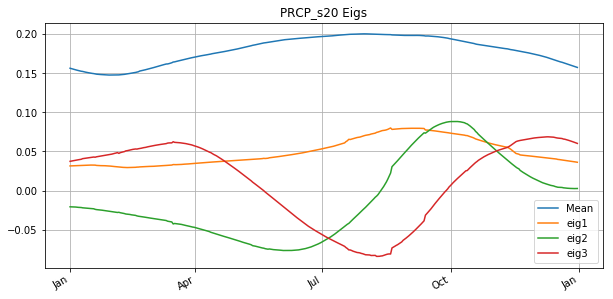

In [20]:
import pylab as plt
fig,axes=plt.subplots(1,1, sharex='col', sharey='row',figsize=(10,5));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
#YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(Combined,fig,axes,title=m+' Eigs',labels=['Mean']+['eig'+str(i+1) for i in range(k)])

* **Eig1** is very similar to the Mean --- Indicates heavy/light snow
* If **coef_1** is large: snow accumulation is higher.

* **Eig2** is positive january, negative march. Indicates early vs. late season
* If **coef_2** is high: snow season is early.

* **Eig3** is positive Feb, negative Jan, March -- Indicates a short or long season.
* If **Coef_3** is high: Season is short.

### Studying the effect of Coefficient 1

In [21]:
df4=df2.filter(df2.res_2<0.1).sort(df2.coeff_1)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

357


In [22]:
# Checking that res_2 is smaller than 0.1 and that rows are sorted based on coeff_2
df4.select('coeff_1','coeff_2','coeff_3','res_1','res_2','res_3',).show(n=4,truncate=14)

+--------------+--------------+--------------+--------------+--------------+--------------+
|       coeff_1|       coeff_2|       coeff_3|         res_1|         res_2|         res_3|
+--------------+--------------+--------------+--------------+--------------+--------------+
|-496.170514...|142.0891167...|-53.8503229...|0.070859013...|0.031252717...|0.011871730...|
|-391.468556...|63.07175638...|-23.9930865...|0.105514602...|0.082295290...|0.078935194...|
|-372.309500...|103.3110146...|-34.7105415...|0.115436660...|0.047326178...|0.039637645...|
|-343.775186...|-60.1073774...|0.905112531...|0.090687811...|0.062889429...|0.062883126...|
+--------------+--------------+--------------+--------------+--------------+--------------+
only showing top 4 rows



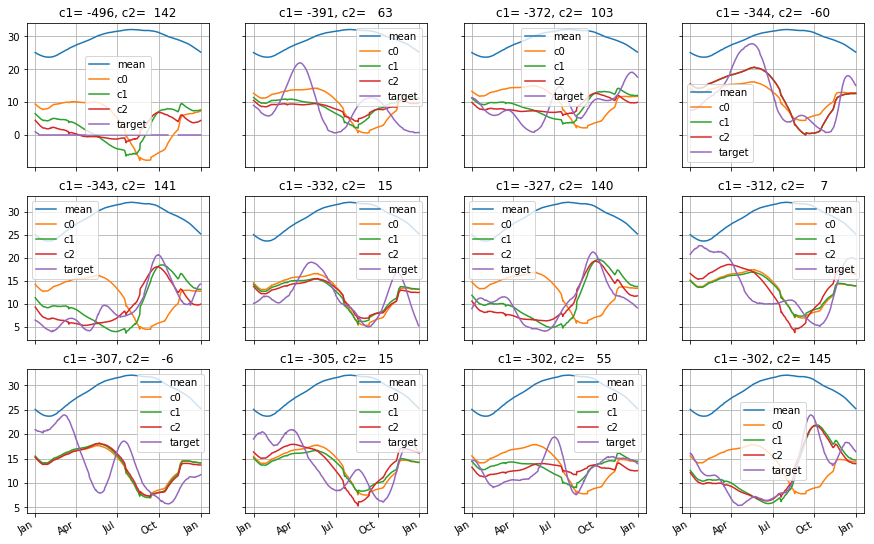

In [23]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='c1=%5.0f, c2=%5.0f',params=('coeff_1','coeff_2'))
savefig('r_figures/SNWD_grid_negative_coeff_2.png')

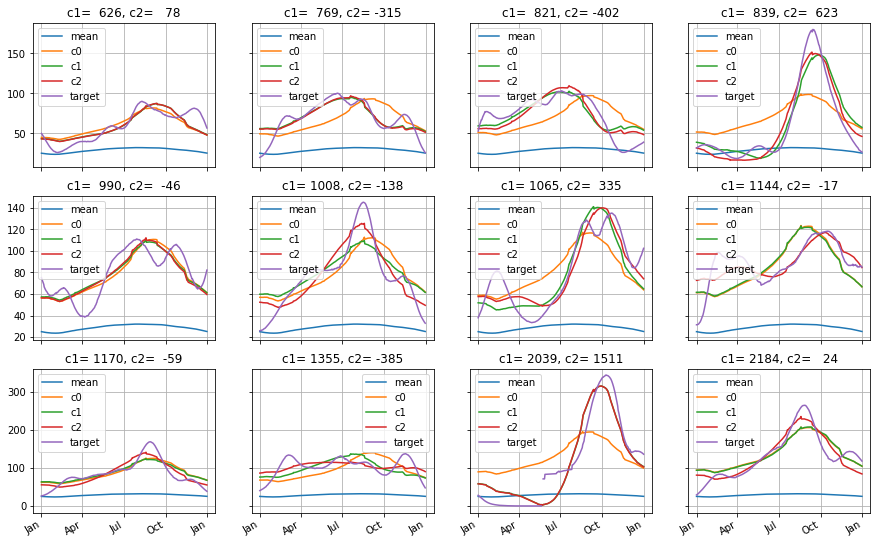

In [24]:
plot_recon_grid(all_rows[-12:],Mean,EigVec,header='c1=%5.0f, c2=%5.0f',params=('coeff_1','coeff_2'))
savefig('r_figures/SNWD_grid_positive_coeff_2.png')

### Studying the effect of Coefficient 2

In [25]:
df4=df2.filter(df2.res_2<0.1).sort(df2.coeff_2)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

357


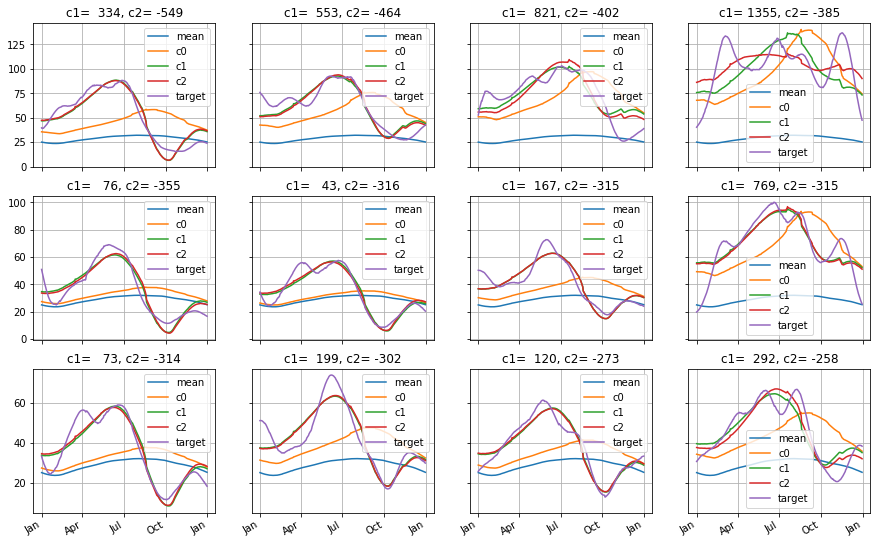

In [26]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='c1=%5.0f, c2=%5.0f',params=('coeff_1','coeff_2'))
savefig('r_figures/SNWD_grid_negative_coeff_3.png')

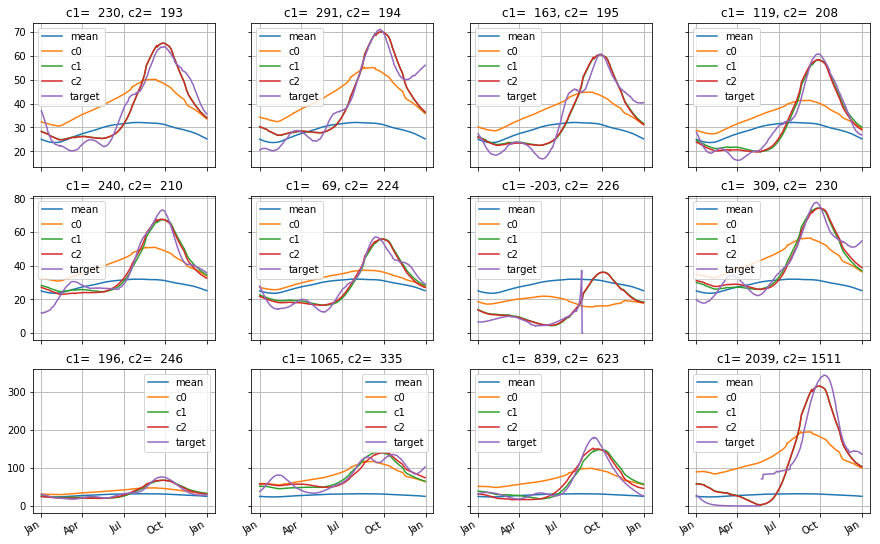

In [27]:
plot_recon_grid(all_rows[-12:],Mean,EigVec,header='c1=%5.0f, c2=%5.0f',params=('coeff_1','coeff_2'))

### Best Fit

First, lets plot the SNWD sequences which are best approximated using the first three eigen-vectors.

In other words, the sequences for which the third residual is smallest.

We can think of these as **architypical** sequences.

In [28]:
df4=df2.sort(df2.res_3)
print(df4.count())
all_rows=df4.collect()
df4.select('coeff_1','coeff_2','coeff_3','res_3').show(n=4,truncate=14)

16118
+--------------+--------------+--------------+--------------+
|       coeff_1|       coeff_2|       coeff_3|         res_3|
+--------------+--------------+--------------+--------------+
|-343.269300...|140.7673740...|-53.7203309...|0.009187131...|
|-296.409032...|24.91257375...|-53.5830828...|0.010476257...|
|-326.579941...|140.3915431...|-33.6786687...|0.011599174...|
|-496.170514...|142.0891167...|-53.8503229...|0.011871730...|
+--------------+--------------+--------------+--------------+
only showing top 4 rows



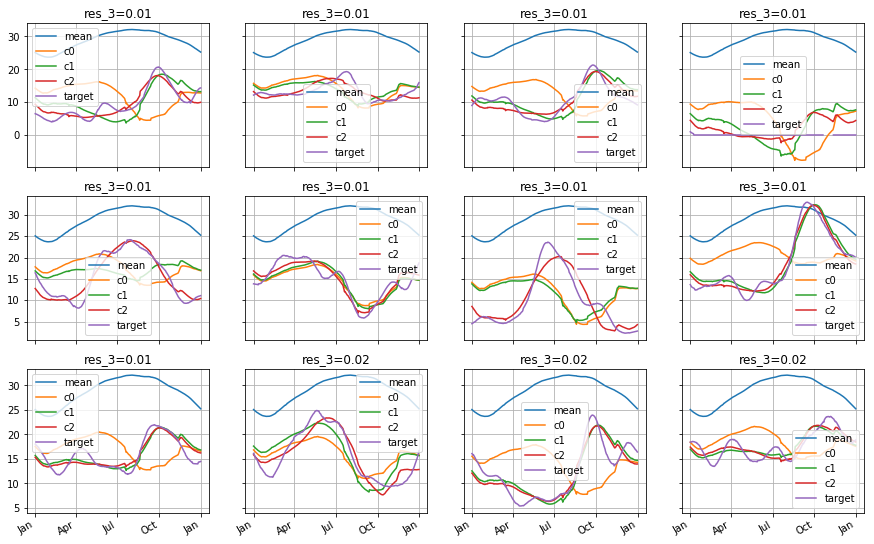

In [29]:
plot_recon_grid(all_rows[:12],Mean,EigVec,header='res_3=%3.2f', params=('res_3',))

## worst fit

Next, lets look at the sequence whose third residual is largest.

We can think of those as **outliers** or **noise**. These seuqnces do not fit our model. 

Have many of these outliers is a problem: we are either getting poor data, or else our model is inadequate.

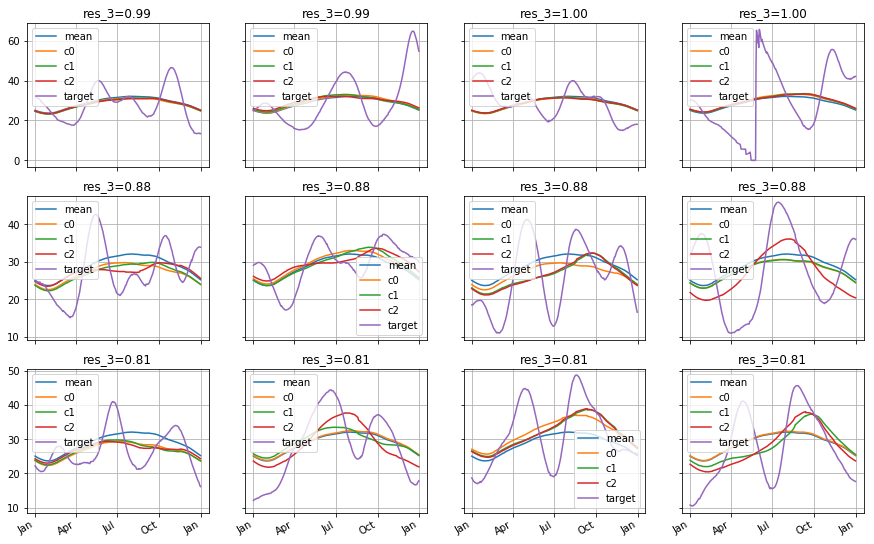

In [30]:
bad_rows=all_rows[-4:]+all_rows[-504:-500]+all_rows[-1004:-1000]
plot_recon_grid(bad_rows,Mean,EigVec,header='res_3=%3.2f', params=('res_3',))

### Something to try
Clearly, the majority of the poor fits are a result of undefined entries in the data.  
Can you change the command to focus on years where most of the measurements are defined?

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [31]:
row=rows[5]
target=np.array(unpackArray(row.Values,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,EigVec)
total_var,residuals,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print('residual normalized norm  after mean:',res[0])
print('residual normalized norm  after mean + top eigs:',res[1:])

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

residual normalized norm  after mean: 0.20619004846712088
residual normalized norm  after mean + top eigs: [0.98313022 0.07097172 0.06565901]


VBox(children=(HBox(children=(FloatSlider(value=0.0, description='c0', max=42.98107431117447, orientation='vertical', step=4.2981074311174465), FloatSlider(value=0.0, description='c1', max=0.0, min=-316.0514422544474, orientation='vertical', step=31.60514422544474), FloatSlider(value=0.0, description='c2', max=24.120192751202172, orientation='vertical', step=2.412019275120217))), Output()))